In [1]:
import pandas as pd
import numpy as np
import gzip
from matplotlib.lines import Line2D


class SOMToolBox_Parse:
    
    def __init__(self, filename):
        self.filename = filename
    
    def read_weight_file(self,):
        df = pd.DataFrame()
        if self.filename[-3:len(self.filename)] == '.gz':
            with gzip.open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)
        else:
            with open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)

        file.close()            
        return df.astype('float64'), vec_dim, xdim, ydim



    def read_class_file(self,):
        df = pd.DataFrame()
        with open(self.filename, 'rb') as file:
            df, xdim, ydim, num_clas, clas_nam = self._read_class_file_to_df(df, file)

        file.close()
        return df.astype('int64'), xdim, ydim, num_clas, clas_nam


    def _read_vector_file_to_df(self, df, file):
        xdim, ydim, vec_dim, position = 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, vec_dim = self._parse_vector_file_metadata(line, xdim, ydim, vec_dim)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim * xdim), columns=range(0, vec_dim))
            else:
                if len(df.columns) == 0 or vec_dim == 0:
                    raise ValueError('Weight file has no correct Dimensional information.')
                position = self._parse_weight_file_data(line, position, vec_dim, df)
        return df, vec_dim, xdim, ydim



    def _read_class_file_to_df(self, df, file):
        xdim, ydim, num_clas, clas_nam, position = 0, 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, num_clas, clas_nam = self._parse_class_file_metadata(line, xdim, ydim, num_clas, clas_nam)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim), columns=['Class'])
            else:
                if len(df.columns) == 0:
                    raise ValueError('Class file has no correct Dimensional information.')
                position = self._parse_class_file_data(line, position, df)
        return df, xdim, ydim, num_clas, clas_nam


    def _parse_weight_file_data(self, line, position, vec_dim, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[0:vec_dim]).astype(float))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.') 
        return  position


    def _parse_class_file_data(self, line, position, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[1:2]).astype(int))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.')
        return  position


    def _parse_vector_file_metadata(self, line, xdim, ydim, vec_dim):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$VEC_DIM': vec_dim = int(splitted[1])
        return xdim, ydim, vec_dim


    def _parse_class_file_metadata(self, line, xdim, ydim, num_clas, clas_nam):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$NUM_CLASSES': num_clas = int(splitted[1])
        elif splitted[0] == '$CLASS_NAMES':
            splitted.pop(0)
            clas_nam = splitted
        return xdim, ydim, num_clas, clas_nam
        

In [2]:
def dot(v,w):
    x,y = v
    X,Y = w
    return x*X + y*Y

def length(v):
    x,y = v
    return math.sqrt(x*x + y*y)

def vector(b,e):
    x,y = b
    X,Y = e
    return (X-x, Y-y)

def unit(v):
    x,y = v
    mag = length(v)
    return (x/mag, y/mag)

def distancee(p0,p1):
    return length(vector(p0,p1))

def scale(v,sc):
    x,y = v
    return (x * sc, y * sc)

def add(v,w):
    x,y = v
    X,Y = w
    return (x+X, y+Y)


# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest
# distance from pnt to the line and the coordinates of the
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line.

def pnt2line(pnt, start, end):
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distancee(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)



def get_bounding_box(polygon):
    bounding = [1, 0, 1, 0]
    for p in polygon:
                if p[0] < bounding[0]:
                    bounding[0] = p[0]
                if p[0] > bounding[1]:
                    bounding[1] = p[0]
                if p[1] < bounding[2]:
                    bounding[2] = p[1]
                if p[1] > bounding[3]:
                    bounding[3] = p[1]
    for i in range(4):
                if bounding[i] > 1:
                    bounding[i] = 1
                if bounding[i] < 0:
                    bounding[i] = 0
                bounding[i] = round(bounding[i], 2)
    return bounding

In [3]:
import numpy as np
from scipy.spatial import distance_matrix, distance
from ipywidgets import Layout, HBox, Box, widgets, interact
import plotly.graph_objects as go
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as mpatches
import math
import plotly.express as px


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) 

class SomViz:
    
    def __init__(self, weights=[], m=None, n=None):
        self.weights = weights
        self.m = m
        self.n = n
        self.xs = 1.0 / n
        self.ys = 1.0 / m
        self.classes = None
        self.cnames = None
        self.ccolors = None
        self.vdiagram = None
        self.vpoints = None
        self.vclasses = None
        self.legend = None

    def addclasses(self, cdata=[], idata=[], cnum=0, cnam=[]):
        self.cnames = cnam
        self.ccolors = []
        self.legend = []
        self.classes = [0] * (self.m * self.n)
        for i in range(0, cnum):
            self.ccolors.append(px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)])
            self.legend.append(mpatches.Patch(color=px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)],
                                              label=cnam[i]))
        for i in range(0, len(self.classes)):
            self.classes[i] = [0] * cnum
        for i, v in enumerate(idata):
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            index = cdata[i]
            self.classes[position][index[0]] = self.classes[position][index[0]] + 1

    def compute_voronoi(self):
        # add dummy vertices so that plane is finite
        self.vpoints = [[-2, -2], [2, 2], [2, -2], [-2, 2]]
        self.vclasses = [len(self.classes[0]) * [0],
                   len(self.classes[0]) * [0],
                   len(self.classes[0]) * [0],
                   len(self.classes[0]) * [0]]
        # position becomes a vpoint if it has a non-empty class array
        for position, v in enumerate(self.classes):
            if sum(v) > 0:
                x,y = position % self.n, position // self.n
                x1 = self.xs * x + (self.xs / 2)
                y1 = self.ys * y + (self.ys / 2)
                self.vpoints.append([x1, y1])
                self.vclasses.append(v)
        # compute Voronoi tesselation
        self.vdiagram = Voronoi(self.vpoints)



    def piecharts(self, som_m=None, scale=False):
        for position, v in enumerate(self.classes):
            x,y = position % self.n, position // self.n
            x1 = self.xs * x
            x2 = self.xs * x + self.xs
            y1 = self.ys * y
            y2 = self.ys * y + self.ys
            if som_m!=None: som_m.add_trace(go.Pie(labels=self.cnames, scalegroup= 1 if scale else None,
                                                   values=v, textinfo='none', domain={'x': [x1, x2], 'y': [y1, y2]},
                                                   marker=dict(colors=px.colors.qualitative.Plotly)))


    def chess(self, pixel_size=0.005, title='Chess'):
        if self.m > self.n:
            plt.rcParams["figure.figsize"] = (6,6/(self.n/self.m))
        elif self.m < self.n:
            plt.rcParams["figure.figsize"] = (6/(self.m/self.n),6)
        else:
            plt.rcParams["figure.figsize"] = (6,6)
        # plot the voronoi diagram
        voronoi_plot_2d(self.vdiagram, show_vertices=False, show_points=False)
        # go over all voronoi cells
        for position in range(4, len(self.vpoints)):
            # get the current polygon
            polygon = [self.vdiagram.vertices[i] for i in self.vdiagram.regions[self.vdiagram.point_region[position]]]
            pclass = self.vclasses[position]
            # fill with the dominant color
            pdomin = pclass.index(max(pclass))
            plt.fill(*zip(*polygon), self.ccolors[pdomin])
            # if dominant color = only color go to next cell
            if pclass.count(0) == len(pclass) - 1:
                continue
            pclassprob = np.nan_to_num(np.array(pclass) / np.sum(np.array(pclass)))
            bounding = get_bounding_box(polygon)
            p = Path(polygon)
            s = np.power(pixel_size, 2)
            # go over all pixels within the bounding box
            for x in np.arange(bounding[0], bounding[1], pixel_size):
                for y in np.arange(bounding[2], bounding[3], pixel_size):
                    # check if the pixel is within the polygon
                    xpoint = x + s
                    ypoint = y + s
                    side = pixel_size - 2 * s
                    pixel_inside = p.contains_points([[xpoint, ypoint],
                                                       [xpoint + side, ypoint + side],
                                                       [xpoint, ypoint + side],
                                                       [xpoint + side, ypoint]])
                    # if the pixel is within the polygon randomly fill it with a class color
                    # (with probability distribution according to the class distribution in that cell)
                    if sum(pixel_inside) == 4:
                        pixel = [[x, y],
                                  [x + pixel_size, y],
                                  [x + pixel_size, y + pixel_size],
                                  [x, y + pixel_size]]
                        plt.fill(*zip(*pixel), self.ccolors[np.random.choice(range(len(self.classes[0])), p=pclassprob)])
        plt.xlim([0,1]), plt.ylim([0,1])
        plt.title(title)
        plt.legend(handles=self.legend, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    def flood(self, pixel_size = 0.005, title='Flood'):
        if self.m > self.n:
            plt.rcParams["figure.figsize"] = (6,6/(self.n/self.m))
        elif self.m < self.n:
            plt.rcParams["figure.figsize"] = (6/(self.m/self.n),6)
        else:
            plt.rcParams["figure.figsize"] = (6,6)
        # save to every vpoint all neighbors that have a common edge
        neighbors_edge  = [[] for _ in range(len(self.vpoints))]
        # save all points at which two vcells meet and which cells meet at that point
        point_neighbors = []
        point_neighbors_point = []
        # position x position matrix that stores the the common points of position x and y
        neighbormatrix = [[[] for _ in range(len(self.vpoints))] for _ in range(len(self.vpoints))]
        # save all edges at which two vcells meet and which cells meet at that edge
        edge_neighbors = []
        edge_neighbors_edge = []

        # fill the point_neighbors list (cap points at 1 and 0)
        for position in range(4, len(self.vpoints)):
            for i in self.vdiagram.regions[self.vdiagram.point_region[position]]:
                x = self.vdiagram.vertices[i][0]
                y = self.vdiagram.vertices[i][1]
                if x > 1:
                    x = 1
                if x < 0:
                    x = 0
                if y > 1:
                    y = 1
                if y < 0:
                    y = 0
                vertex = (x, y)
                if vertex in point_neighbors:
                    index = point_neighbors.index(vertex)
                    point_neighbors_point[index].append(position)
                else:
                    point_neighbors.append(vertex)
                    point_neighbors_point.append([position])
        # fill the neighboring matrix
        for index, p in enumerate(point_neighbors_point):
            for i in p:
                for j in p:
                    if i != j:
                        neighbormatrix[i][j].append(point_neighbors[index])
        # fill the edge_neighbors list
        for i, p in enumerate(neighbormatrix):
            for j, px in enumerate(p):
                if len(px) == 2:
                    neighbors_edge[i].append(j) if j not in neighbors_edge[i] else neighbors_edge[i]
                    neighbors_edge[j].append(i) if i not in neighbors_edge[j] else neighbors_edge[j]
                    edge_neighbors.append([(px[0][0] + px[1][0]) / 2, (px[0][1] + px[1][1]) / 2])
                    edge_neighbors.append([(px[0][0] + px[1][0]) / 2, (px[0][1] + px[1][1]) / 2])
                    edge_neighbors_edge.append([i, j])
                    edge_neighbors_edge.append([j, i])
        # plot the voronoi diagram
        voronoi_plot_2d(self.vdiagram, show_vertices=False, show_points=False)
        # go over all voronoi cells
        for position in range(4, len(self.vpoints)):
            # get the current polygon
            polygon = [self.vdiagram.vertices[i] for i in self.vdiagram.regions[self.vdiagram.point_region[position]]]
            pclass = self.vclasses[position]
            pdomin = pclass.index(max(pclass))
            # fill with the dominant color
            plt.fill(*zip(*polygon), self.ccolors[pdomin])
            # if dominant color = only color go to next cell
            if pclass.count(0) == len(pclass) - 1:
                continue
            bounding = get_bounding_box(polygon)
            p = Path(polygon)
            pclassprobs = np.nan_to_num(np.array(pclass) / np.sum(np.array(pclass)))
            pattractors = [[] for _ in range(len(pclassprobs))]
            # for each class that is not the dominant class and not empty in this cell compute the attractos
            for i, pclassprob in enumerate(pclassprobs):
                if pclassprob > 0 and i != pdomin:
                    # find all edge neighbors that also feature the class
                    p_edge_neighbors = []
                    for neighbor in neighbors_edge[position]:
                        nclass = self.vclasses[neighbor]
                        if nclass[i] > 0:
                            p_edge_neighbors.append(neighbor)
                    # if there are no edge neighbors add the voronoi vertex as an attractor
                    if len(p_edge_neighbors) == 0:
                        pattractors[i].append([self.vpoints[position]])
                    # if there is exactly one edge neighbor add a line from the voronoi vertex to the mid
                    # point of that edge as an attractor
                    if len(p_edge_neighbors) == 1:
                        pattractors[i].append([self.vpoints[position],
                                               edge_neighbors[edge_neighbors_edge.index([position, p_edge_neighbors[0]])]])
                    # If there are more than one edge neighbors first compute all the ones that are isolated, i.e.
                    # if a edge neighbor n1 of the current position does not have another edge neighbor n2 that also
                    # features the searched class and also does not have a edge neighbor n2 that is only separated
                    # by 1 other shared edge neighbor n3 of n1 and n2 (that also features teh searched class) then the
                    # neighbor is isolated
                    if len(p_edge_neighbors) > 1:
                        isolated = []
                        for n1 in p_edge_neighbors:
                            none = True
                            for n2 in p_edge_neighbors:
                                if not none:
                                    break
                                if n1 != n2:
                                    if n2 in neighbors_edge[n1]:
                                        none = False
                                    n3s = [value for value in neighbors_edge[n1] if value in neighbors_edge[n2]]
                                    for n3 in n3s:
                                        if n3 != position and self.vclasses[n3][i] > 0:
                                            none = False
                            if none:
                                isolated.append(n1)
                        # for each isolated neighbor we add a line from the voronoi vertex to the mid point of
                        # that edge as an attractor
                        for n1 in isolated:
                            pattractors[i].append([self.vpoints[position],
                                                   edge_neighbors[edge_neighbors_edge.index([position, n1])]])
                        # For all edge neighbors n1 of the current position go over all edge neighbors n2
                        # of the current position and check:
                        # If n1 and n2 are also edge neighbors then check if there exists isolated neighbors
                        # - If yes: Add a line attractor from the voronoi vertex to the intersection point of n1, n2
                        # and the current position
                        # - If no: Only add the intersection point of n1, n2 and the current position as an attractor
                        # If n1 and n2 are not direct edge neighbors but they both share a common edge neighbor n3,
                        # that is not the current position and also has the searched class do the same as above
                        for n1 in p_edge_neighbors:
                            for n2 in p_edge_neighbors:
                                if n1 != n2:
                                    if n2 in neighbors_edge[n1]:
                                        for index, ni in enumerate(point_neighbors_point):
                                            if position in ni and n1 in ni and n2 in ni:
                                                nx = point_neighbors[index]
                                                if len(isolated) == 0:
                                                    pattractors[i].append([[nx[0], nx[1]]])
                                                else:
                                                    pattractors[i].append([self.vpoints[position], [nx[0], nx[1]]])
                                    else:
                                        n3s = [value for value in neighbors_edge[n1] if value in neighbors_edge[n2]]
                                        for n3 in n3s:
                                            if n3 != position and self.vclasses[n3][i] > 0:
                                                for index, ni in enumerate(point_neighbors_point):
                                                    if position in ni and n1 in ni and n2 in ni:
                                                        nx = point_neighbors[index]
                                                        if len(isolated) == 0:
                                                            pattractors[i].append([[nx[0], nx[1]]])
                                                        else:
                                                            pattractors[i].append([self.vpoints[position], [nx[0], nx[1]]])
                                                break
            pcube = [[] for _ in range(len(pclassprobs))]
            s = np.power(pixel_size, 2)
            # go over all pixels within the bounding box
            for x in np.arange(bounding[0], bounding[1], pixel_size):
                for y in np.arange(bounding[2], bounding[3], pixel_size):
                    # check if the pixel is within the polygon
                    xpoint = x + s
                    ypoint = y + s
                    side = pixel_size - 2 * s
                    pixel_inside = p.contains_points([[xpoint, ypoint],
                                                       [xpoint + side, ypoint + side],
                                                       [xpoint, ypoint + side],
                                                       [xpoint + side, ypoint]])
                    if sum(pixel_inside) == 4:
                        # if the pixel is within the polygon go over all classes and for each class over all its
                        # attractors. Calculate the minimum distance to each attractor and the add the polygon
                        # with the distance information list of all polygons for that class
                        for i, attraci in enumerate(pattractors):
                            dist = 1
                            for attrac in attraci:
                                mdist = 1
                                if len(attrac) == 1:
                                    XA = [(x + pixel_size / 2, y + pixel_size / 2)]
                                    XB = [(attrac[0][0], attrac[0][1])]
                                    mdist = distance.cdist(XA, XB, 'euclidean')
                                if len(attrac) == 2:
                                    px = [x + (pixel_size / 2), y + (pixel_size / 2)]
                                    p0 = [attrac[0][0], attrac[0][1]]
                                    p1 = [attrac[1][0], attrac[1][1]]
                                    mdist, nearest = pnt2line(px, p0, p1)
                                if mdist < dist:
                                    dist = mdist
                            pcube[i].append((dist, [[x, y],
                                      [x + pixel_size, y],
                                      [x + pixel_size, y + pixel_size],
                                      [x, y + pixel_size]])) if (dist, [[x, y],
                                      [x + pixel_size, y],
                                      [x + pixel_size, y + pixel_size],
                                      [x, y + pixel_size]]) not in pcube else pcube
            # sort the pixels according to the distance to their attractor
            for i in pcube:
                i.sort()
            # calculate how many pixels each class gets to have in that cell
            ppixels = []
            for pclassprob in pclassprobs:
                ppixels.append(math.ceil(len(pcube[0]) * pclassprob))
            # go over all classes and if it is not the dominant one, color the amount of pixels that this
            # class gets in order by the attractor sorted pixel array
            for i, ppixel in enumerate(ppixels):
                if i != pdomin:
                    for polyin in range(ppixel):
                        if polyin < len(pcube[i]):
                            plt.fill(*zip(*pcube[i][polyin][1]), self.ccolors[i])
        plt.xlim([0,1]), plt.ylim([0,1])
        #for i,p in enumerate(points):
        #    plt.text(p[0], p[1], '#%d' % i)
        #plt.triplot(np.array(points)[:,0], np.array(points)[:,1], dela.simplices)
        plt.title(title)
        plt.legend(handles=self.legend, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    def umatrix(self, som_map=None, color="Viridis", interp = "best", title=""):
        um =np.zeros((self.m *self.n, 1))
        neuron_locs = list()
        for i in range(self.m):
            for j in range(self.n):
                neuron_locs.append(np.array([i, j]))
        neuron_distmat = distance_matrix(neuron_locs,neuron_locs)

        for i in range(self.m * self.n):
            neighbor_idxs = neuron_distmat[i] <= 1
            neighbor_weights = self.weights[neighbor_idxs]
            um[i] = distance_matrix(np.expand_dims(self.weights[i], 0), neighbor_weights).mean()

        if som_map==None: return self.plot(um.reshape(self.m,self.n), color=color, interp=interp, title=title)
        else: som_map.data[0].z = um.reshape(self.m,self.n)

    def hithist(self, som_map=None, idata = [], color='RdBu', interp = "best", title=""):
        hist = [0] *self.n *self.m
        for v in idata: 
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            hist[position] += 1    
        
        if som_map==None: return self.plot(np.array(hist).reshape(self.m,self.n), color=color, interp=interp, title=title)        
        else:  som_map.data[0].z = np.array(hist).reshape(self.m,self.n)

    def component_plane(self, som_map=None, component=0, color="Viridis", interp = "best", title=""):
        if som_map==None: return self.plot(self.weights[:,component].reshape(-1,self.n), color=color, interp=interp, title=title)   
        else:  som_map.data[0].z = self.weights[:,component].reshape(-1,self.n)

    def sdh(self, som_map=None, idata=[], sdh_type=1, factor=1, draw=True, color="Cividis", interp = "best", title=""):

        import heapq
        sdh_m = [0] *self.m *self.n

        cs=0
        for i in range(0,factor): cs += factor-i

        for vector in idata:
            dist = np.sqrt(np.sum(np.power(self.weights - vector, 2), axis=1))
            c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
            if (sdh_type==1): 
                for j in range(0,factor):  sdh_m[c[j]] += (factor-j)/cs # normalized
            if (sdh_type==2):
                for j in range(0,factor): sdh_m[c[j]] += 1.0/dist[c[j]] # based on distance
            if (sdh_type==3): 
                dmin = min(dist)
                for j in range(0,factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(max(dist)-dmin)  

        if som_map==None: return self.plot(np.array(sdh_m).reshape(-1,self.n), color=color, interp=interp, title=title)      
        else: som_map.data[0].z = np.array(sdh_m).reshape(-1,self.n)

        
    def project_data(self,som_m=None, idata=[], title=""):

        data_y = []
        data_x = []
        for v in idata:
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            x,y = position % self.n, position // self.n
            data_x.extend([x])
            data_y.extend([y])
            
        if som_m!=None: som_m.add_trace(go.Scatter(x=data_x, y=data_y, mode = "markers", marker_color='rgba(255, 255, 255, 0.8)',))
    
    def time_series(self, som_m=None, idata=[], wsize=50, title=""): #not tested
             
        data_y = []
        data_x = [i for i in range(0,len(idata))]
        
        data_x2 = []
        data_y2 = []
        
        qmin = np.Inf
        qmax = 0
        
        step=1
        
        ps = []
        for v in idata:
            matrix = np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1))
            position = np.argmin(matrix)
            qerror = matrix[position]
            if qmin>qerror: qmin = qerror
            if qmax<qerror: qmax = qerror
            ps.append((position, qerror))
       
        markerc=[]    
        for v in ps:
            data_y.extend([v[0]])
            rez = v[1]/qmax
 
            markerc.append('rgba(0, 0, 0, '+str(rez)+')') 
            
            x,y = v[0] % self.n, v[0] // self.n 
            if    x==0: y = np.random.uniform(low=y, high=y+.1)
            elif  x==self.m-1: y = np.random.uniform(low=y-.1, high=y)
            elif  y==0: x = np.random.uniform(low=x, high=x+.1)
            elif  y==self.n-1: x = np.random.uniform(low=x-.1, high=x)
            else: x,y = np.random.uniform(low=x-.1, high=x+.1), np.random.uniform(low=y-.1, high=y+.1)                           
            
            data_x2.extend([x])
            data_y2.extend([y]) 
    
        ts_plot = go.FigureWidget(go.Scatter(x=[], y=[], mode = "markers", marker_color=markerc, marker=dict(colorscale='Viridis', showscale=True, color=np.random.randn(500))))
        ts_plot.update_xaxes(range=[0, wsize])       

        
        ts_plot.data[0].x, ts_plot.data[0].y = data_x, data_y
        som_m.add_trace(go.Scatter(x=data_x2, y=data_y2, mode = "markers",))
  
        som_m.layout.height = 500
        ts_plot.layout.height = 500
        som_m.layout.width = 500
        ts_plot.layout.width = 1300
        
        return HBox([go.FigureWidget(som_m), go.FigureWidget(ts_plot)])
    
    def plot(self, matrix, color="Viridis", interp = "best", title=""):
        width = 600
        height = 600
        if self.m > self.n:
            width = width/(self.m/self.n)
        elif self.m < self.n:
            height = height/(self.n/self.m)
        return go.FigureWidget(go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color), layout=go.Layout(width=width, height=height,title=title, title_x=0.5,))


In [4]:

import pandas as pd
import minisom as som
from sklearn import datasets, preprocessing
import matplotlib.image as img
#interp: False, 'best', 'fast',
#color = 'viridis': https://plotly.com/python/builtin-colorscales/



#############################
######## miniSOM ############1/0
#############################
m=10
n=10

# Pre-processing
iris = datasets.load_iris().data
min_max_scaler = preprocessing.MinMaxScaler()
iris = min_max_scaler.fit_transform(iris)

# Train
s = som.MiniSom(m, n, iris.shape[1], sigma=0.8, learning_rate=0.7)
s.train_random(iris, 10000, verbose=False)

# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,4), m, n)
um1 = viz_miniSOM.umatrix(color='magma', interp='best', title='U-matrix miniSOM')


##########################################
######## read from SOMToolBox ############
##########################################
trainedmap = SOMToolBox_Parse('iris.vec')
idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

smap = SOMToolBox_Parse('somtoolbox/iris.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um2 = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix SOMToolBox')

#display(HBox([um1, um2]))
um1.show(renderer='svg')
um2.show(renderer='svg')


    'data': [{'colorscale': [[0.0, '#000004'], [0.1111111111111111, '#180f3d'],
…

 Chainlink Custom (from Toolbox) 40x20

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

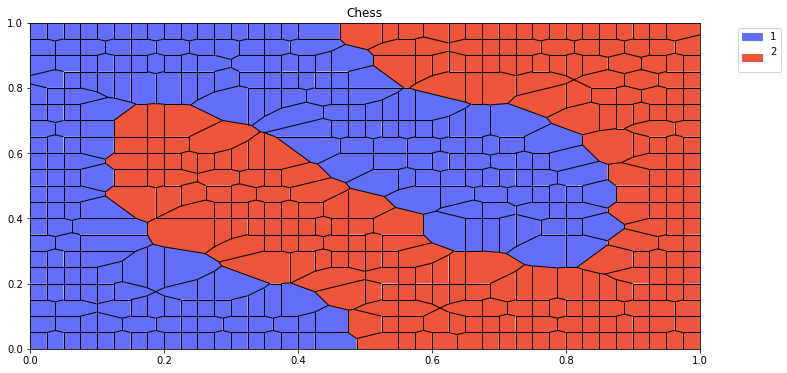

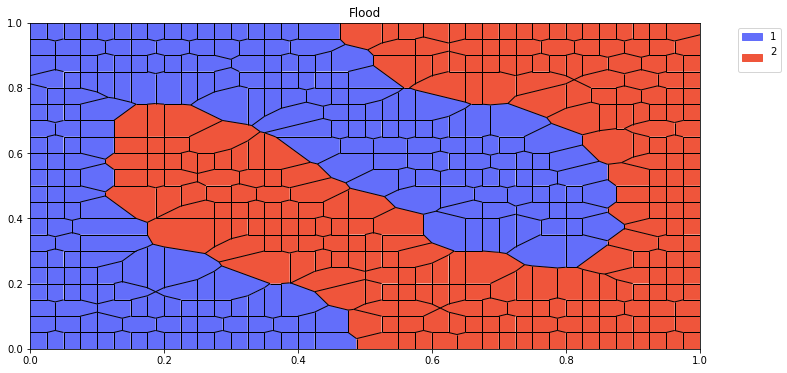

In [5]:
ogvalues = SOMToolBox_Parse('chainlink.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('data/chainlink-custom-40-20/chainlink-custom.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('chainlink.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()

 Chainlink Custom (from MiniSom) 40x20

 [ 10000 / 10000 ] 100% 0.01182 it/s

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

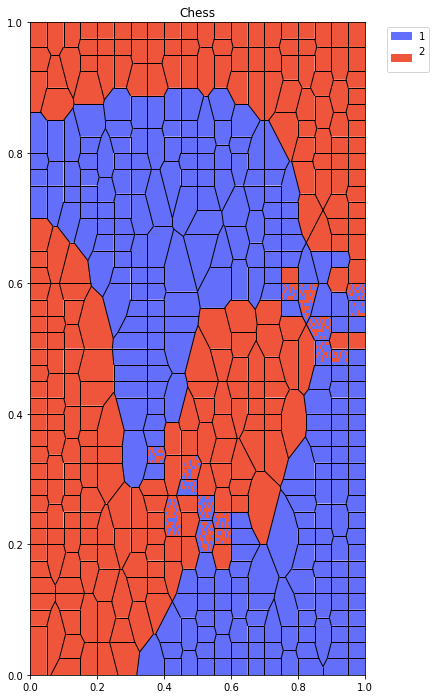

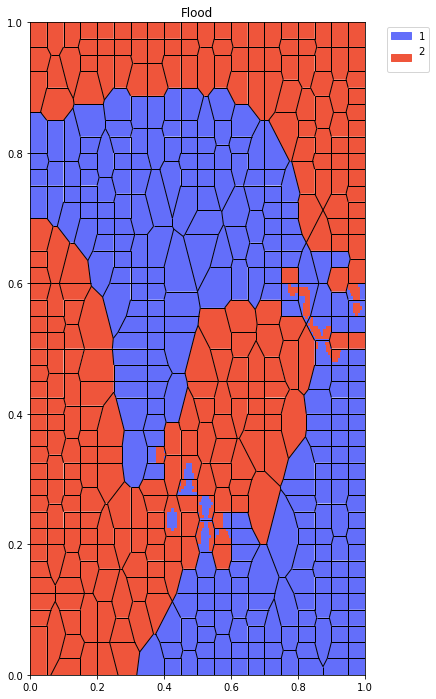

In [6]:
m=40
n=20

ogvalues = SOMToolBox_Parse('chainlink.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
scaled = min_max_scaler.fit_transform(idata)

# Train
s = som.MiniSom(m, n, scaled.shape[1], sigma=2.5, learning_rate=0.7)
s.train_batch(scaled, 10000, verbose=True)

classmap = SOMToolBox_Parse('chainlink.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()
# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,3), m, n)
um = viz_miniSOM.umatrix(color='viridis', interp=False, title='U-matrix')
viz_miniSOM.addclasses(cdata=cdata.values, idata=scaled, cnum=cnum, cnam=cnam)
viz_miniSOM.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_miniSOM.compute_voronoi()
viz_miniSOM.chess()
viz_miniSOM.flood()

 Chainlink Custom (from Toolbox) 100x60

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

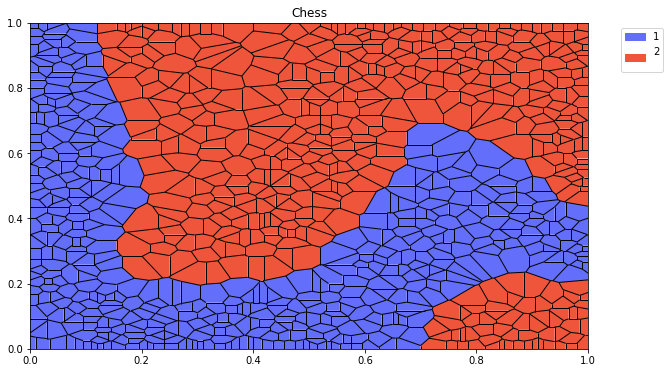

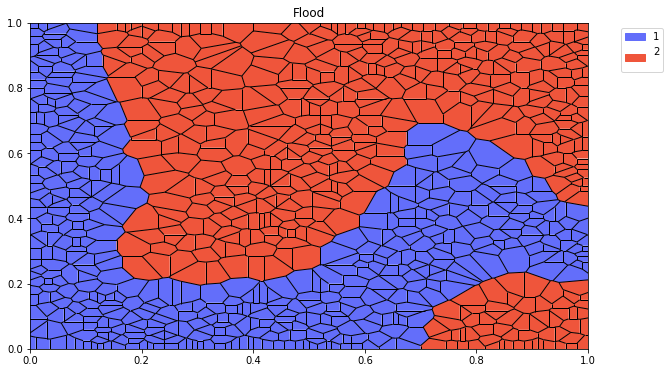

In [7]:
ogvalues = SOMToolBox_Parse('chainlink.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('data/chainlink-custom-100-60/chainlink-custom.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('chainlink.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()

 Chainlink Custom (from MiniSom) 40x20

 [ 10000 / 10000 ] 100% 0.07612 it/s

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

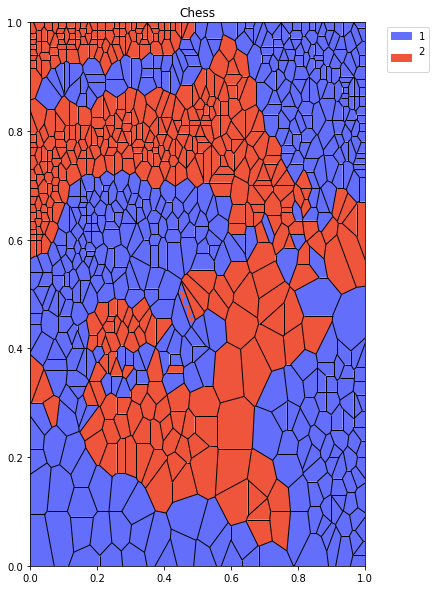

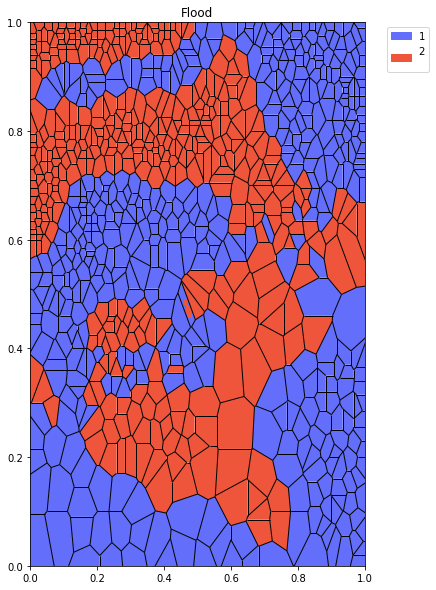

In [8]:
m=100
n=60

ogvalues = SOMToolBox_Parse('chainlink.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
scaled = min_max_scaler.fit_transform(idata)

# Train
s = som.MiniSom(m, n, scaled.shape[1], sigma=2.5, learning_rate=0.7)
s.train_batch(scaled, 10000, verbose=True)

classmap = SOMToolBox_Parse('chainlink.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()
# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,3), m, n)
um = viz_miniSOM.umatrix(color='viridis', interp=False, title='U-matrix')
viz_miniSOM.addclasses(cdata=cdata.values, idata=scaled, cnum=cnum, cnam=cnam)
viz_miniSOM.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_miniSOM.compute_voronoi()
viz_miniSOM.chess()
viz_miniSOM.flood()

 10clusters Custom (from Toolbox) 40x20

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

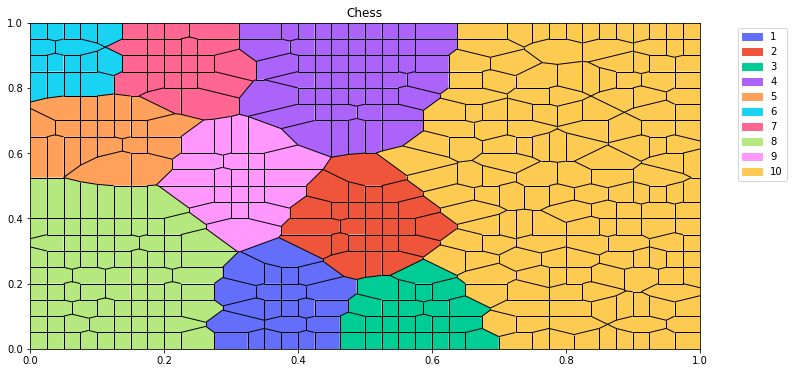

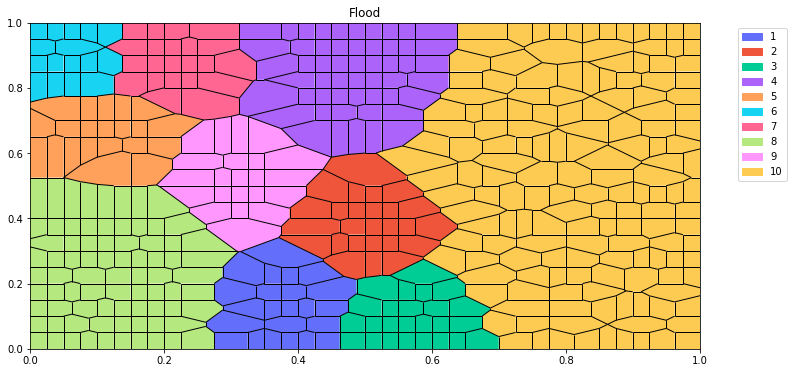

In [9]:
ogvalues = SOMToolBox_Parse('10clusters.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('data/10clusters-custom-40-20/10clusters-custom.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('10clusters.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()


 10clusters Custom (from MiniSom) 40x20

 [ 10000 / 10000 ] 100% 0.01122 it/s

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

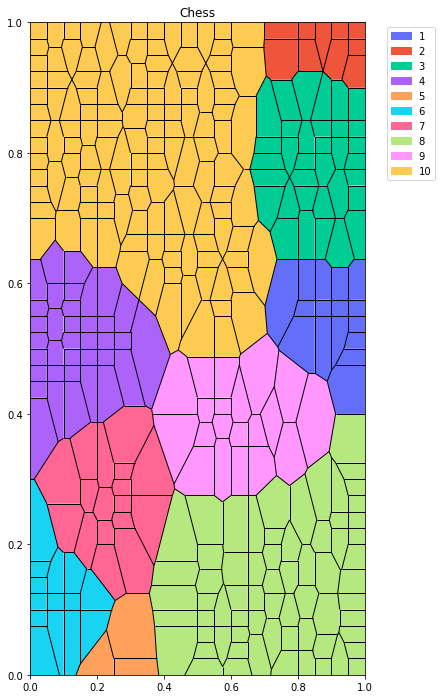

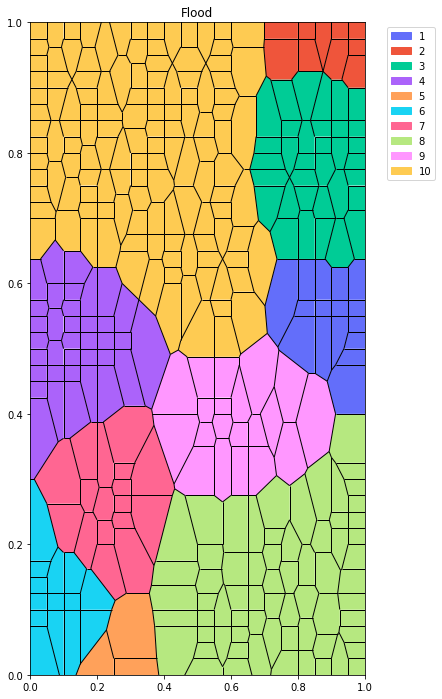

In [10]:
m=40
n=20

ogvalues = SOMToolBox_Parse('10clusters.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
scaled = min_max_scaler.fit_transform(idata)

# Train
s = som.MiniSom(m, n, scaled.shape[1], sigma=2.5, learning_rate=0.7)
s.train_batch(scaled, 10000, verbose=True)

classmap = SOMToolBox_Parse('10clusters.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()
# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,10), m, n)
um = viz_miniSOM.umatrix(color='viridis', interp=False, title='U-matrix miniSOM')
viz_miniSOM.addclasses(cdata=cdata.values, idata=scaled, cnum=cnum, cnam=cnam)
viz_miniSOM.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_miniSOM.compute_voronoi()
viz_miniSOM.chess()
viz_miniSOM.flood()

 10clusters Custom 100x60

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

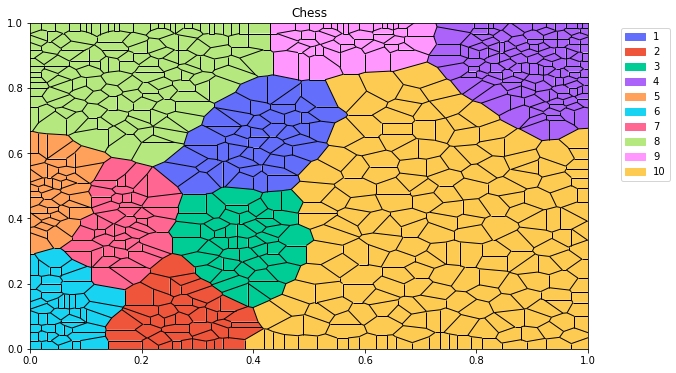

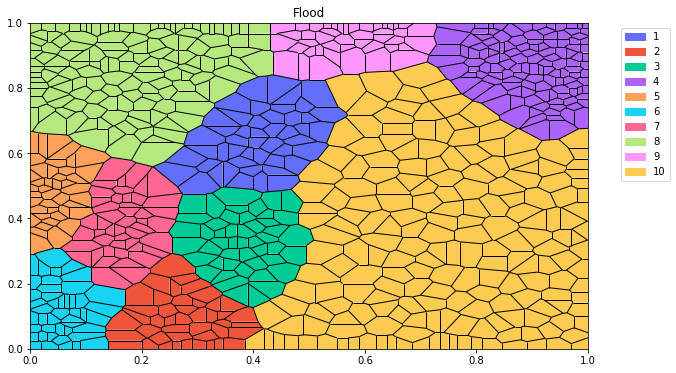

In [11]:
ogvalues = SOMToolBox_Parse('10clusters.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('data/10clusters-custom-100-60/10clusters-custom.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('10clusters.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()


 10clusters Custom (from MiniSom) 100x60

 [ 10000 / 10000 ] 100% 0.07352 it/s

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

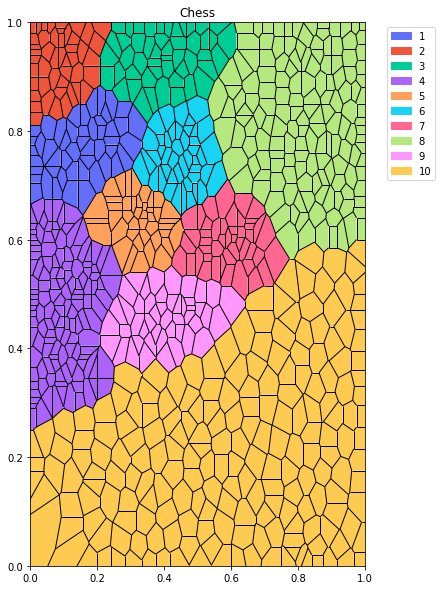

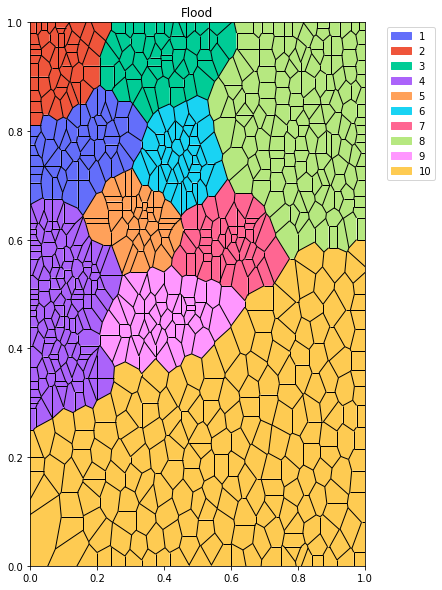

In [12]:
m=100
n=60

ogvalues = SOMToolBox_Parse('10clusters.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
scaled = min_max_scaler.fit_transform(idata)

# Train
s = som.MiniSom(m, n, scaled.shape[1], sigma=2.5, learning_rate=0.7)
s.train_batch(scaled, 10000, verbose=True)

classmap = SOMToolBox_Parse('10clusters.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()
# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,10), m, n)
um = viz_miniSOM.umatrix(color='viridis', interp=False, title='U-matrix miniSOM')
viz_miniSOM.addclasses(cdata=cdata.values, idata=scaled, cnum=cnum, cnam=cnam)
viz_miniSOM.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_miniSOM.compute_voronoi()
viz_miniSOM.chess()
viz_miniSOM.flood()

 10clusters pre-trained (our viz)

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

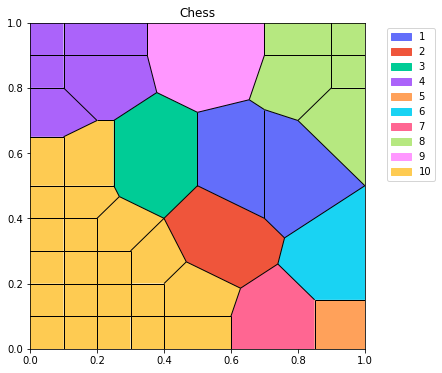

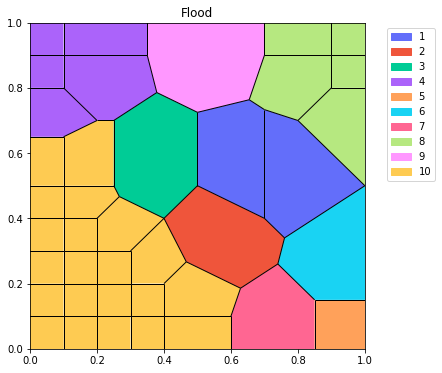

In [13]:
ogvalues = SOMToolBox_Parse('10clusters.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('somtoolbox/10clusters.wgt')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('10clusters.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()

 10clusters pre-trained (toolbox viz)

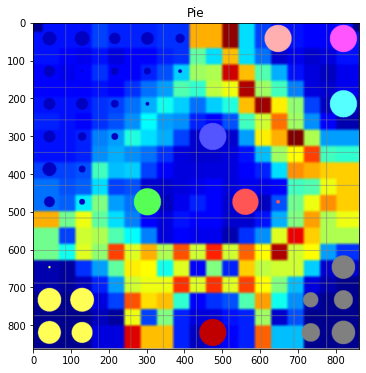

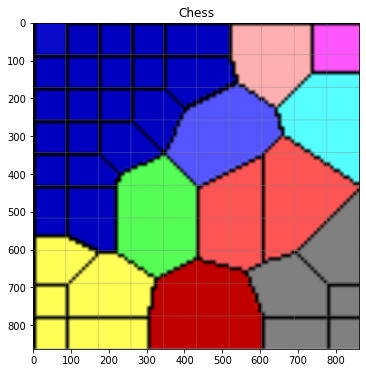

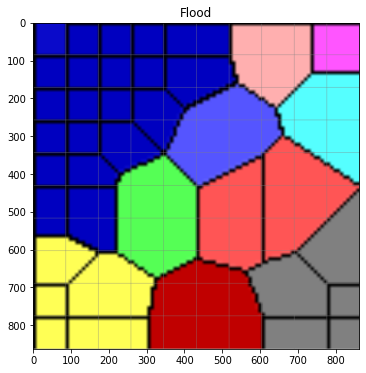

In [14]:
im = img.imread('toolbox_viz/10clusters_pie.png')
plt.title('Pie')
plt.imshow(im)
plt.show()
im = img.imread('toolbox_viz/10clusters_chess.png')
plt.title('Chess')
plt.imshow(im)
plt.show()
im = img.imread('toolbox_viz/10clusters_chess.png')
plt.title('Flood')
plt.imshow(im)
plt.show()

 Chainlink pre-trained (our viz)

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

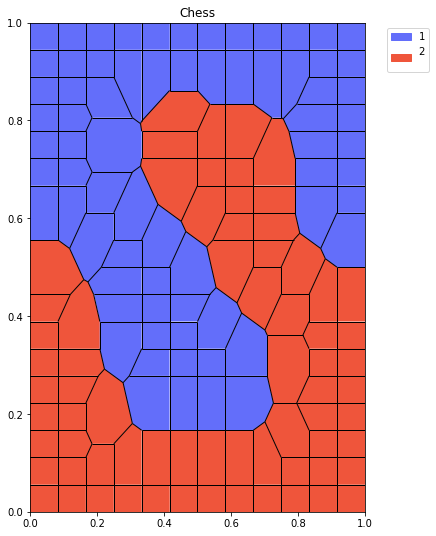

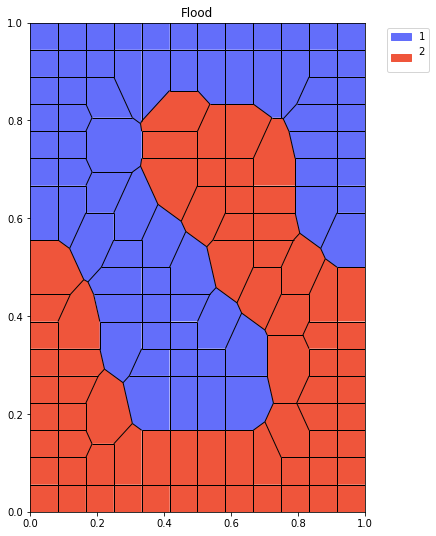

In [15]:
ogvalues = SOMToolBox_Parse('chainlink.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('somtoolbox/chainlink.wgt')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('chainlink.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()

 Chainlink pre-trained (toolbox viz)

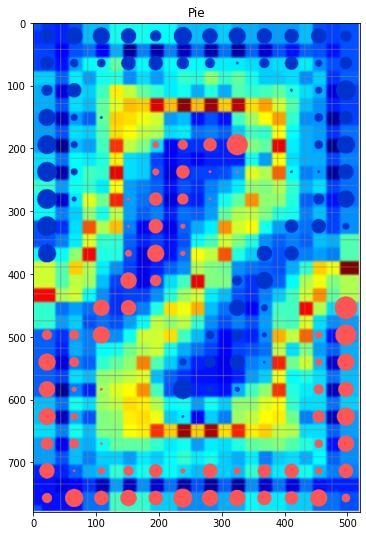

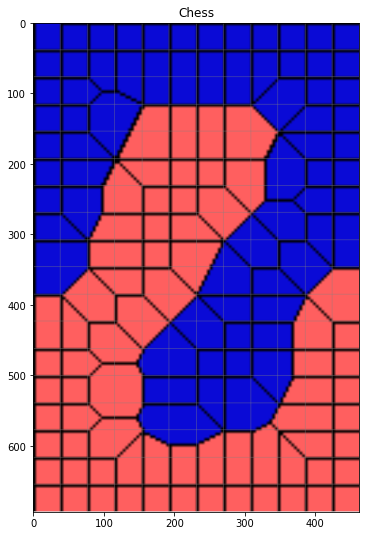

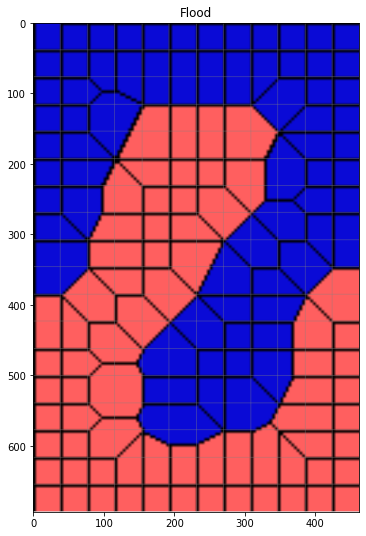

In [16]:
im = img.imread('toolbox_viz/chainlink_pie.png')
plt.title('Pie')
plt.imshow(im)
plt.show()
im = img.imread('toolbox_viz/chainlink_chess.png')
plt.title('Chess')
plt.imshow(im)
plt.show()
im = img.imread('toolbox_viz/chainlink_chess.png')
plt.title('Flood')
plt.imshow(im)
plt.show()

 Boston Housing pre-trained (our viz)

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

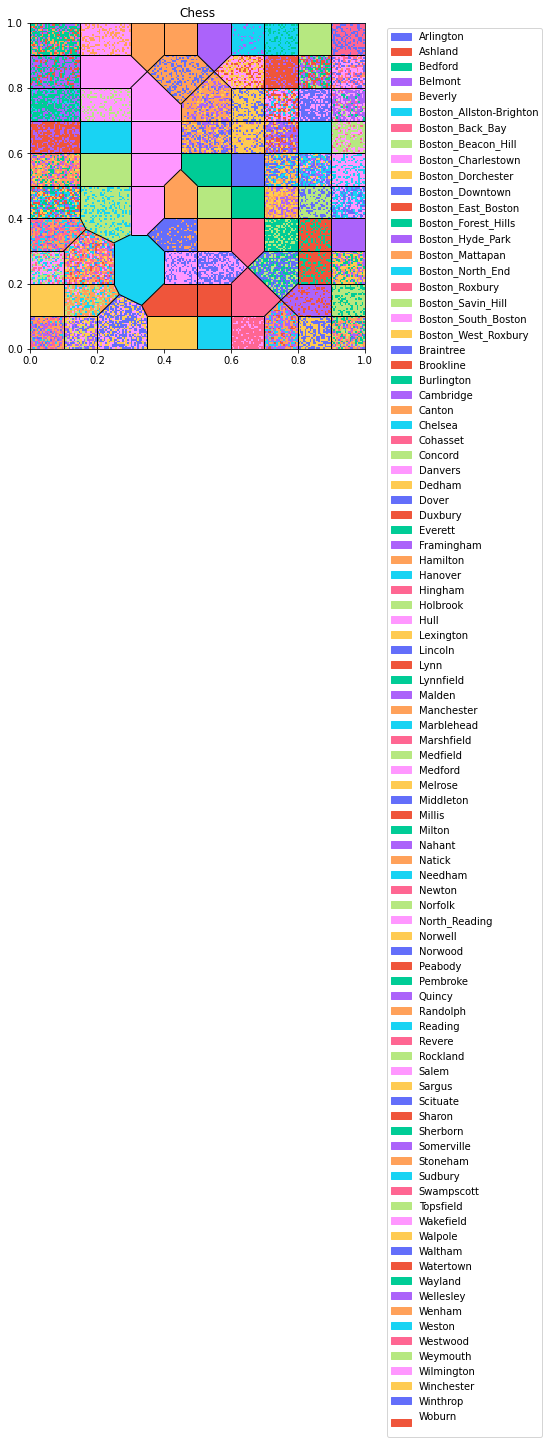

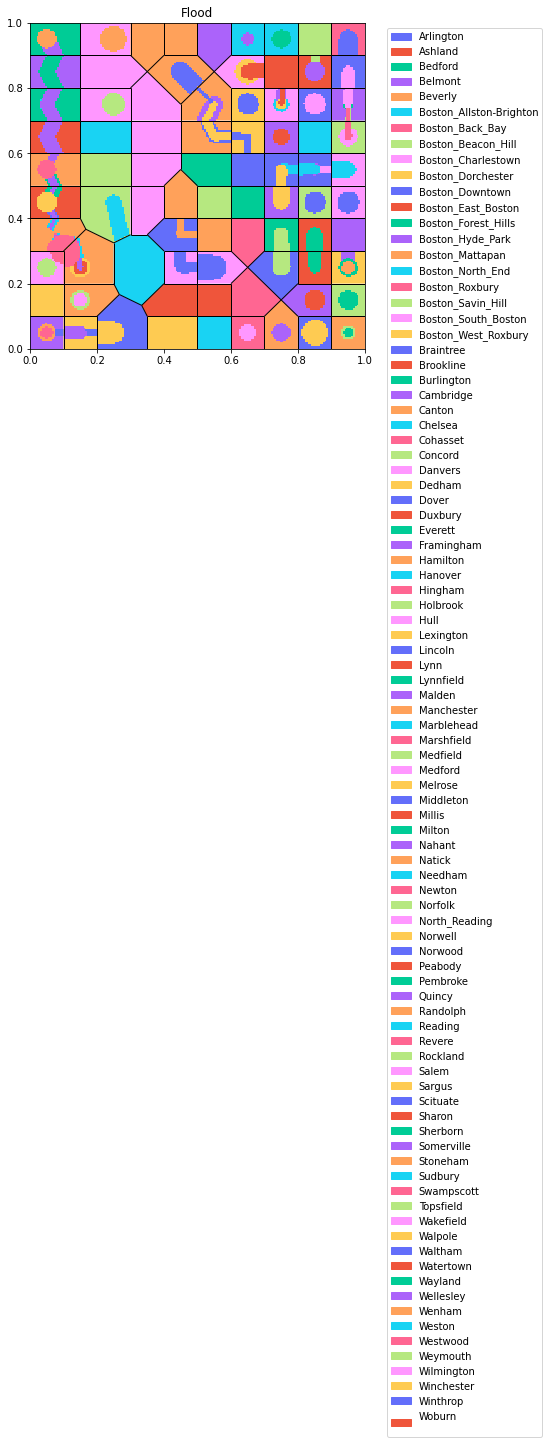

In [17]:
ogvalues = SOMToolBox_Parse('boston-housing.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
smap = SOMToolBox_Parse('somtoolbox/boston-housing.wgt')
smap, sdim, smap_x, smap_y = smap.read_weight_file()
classmap = SOMToolBox_Parse('boston-housing.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix')
viz_SOMToolBox.addclasses(cdata=cdata.values, idata=idata.values, cnum=cnum, cnam=cnam)
viz_SOMToolBox.piecharts(som_m=um, scale=True)

um.show(renderer='svg')

viz_SOMToolBox.compute_voronoi()
viz_SOMToolBox.chess()
viz_SOMToolBox.flood()

 Boston Housing pre-trained (toolbox viz)

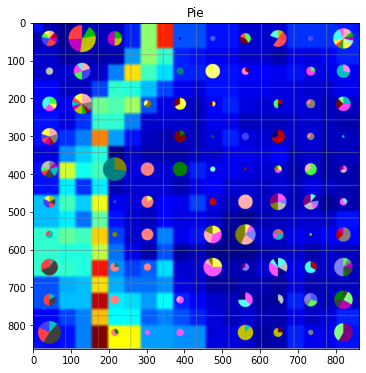

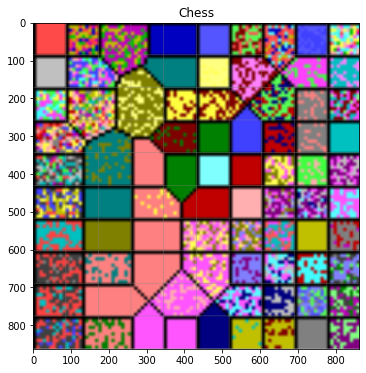

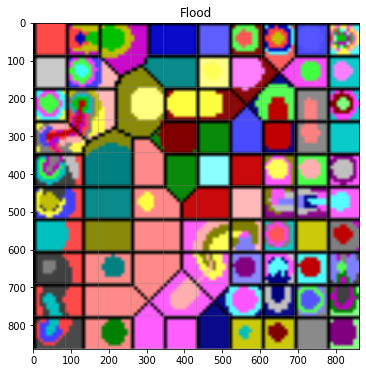

In [18]:
im = img.imread('toolbox_viz/boston-housing_pie.png')
plt.title('Pie')
plt.imshow(im)
plt.show()
im = img.imread('toolbox_viz/boston-housing_chess.png')
plt.title('Chess')
plt.imshow(im)
plt.show()
im = img.imread('toolbox_viz/boston-housing_flooding.png')
plt.title('Flood')
plt.imshow(im)
plt.show()